In [1]:
!ls ./checkpoint/

DRIT_concat_black2blond_gan_4layer_4dis_3scale_3con
DRIT_concat_black2blond_gan_4layer_4dis_3scale_3con.zip
DRIT_concat_black2brown_gan_4layer_4dis_3scale_3con
DRIT_concat_black_nosmile2blond_smile_gan_4layer_4dis_3scale_3con
DRIT_concat_brown2blond_gan_4layer_4dis_3scale_3con
DRIT_concat_facial_hair2nofacial_hair_gan_4layer_4dis_3scale_3con
DRIT_concat_fh_male2nofh_female_gan_4layer_4dis_3scale_3con
DRIT_concat_makeup_lib2another_gan_4layer_4dis_3scale_3con
DRIT_concat_male2female_gan_4layer_4dis_3scale_3con
DRIT_concat_smile2nosmile_gan_4layer_4dis_3scale_3con
DRIT_concat_Wearing_Lipstick2another_gan_4layer_4dis_3scale_3con
__MACOSX


In [1]:
from DRIT import DRIT
import argparse
from utils import *
import pandas as pd
from PIL import Image, ImageDraw
from glob import glob
from utils import *

/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def concat_image(images,nrows, ncols):
    width = 128
    height = 128
    
    background = Image.new('RGBA',(128*ncols, 128*nrows), (255, 255, 255, 255))
    bg_w, bg_h = background.size
    
    for i,image in enumerate(images):
    #print(i)
        img = image
        draw = ImageDraw.Draw(img, "RGB")
        #font = ImageFont.truetype("/Library/Fonts/Arial.ttf",50)
        #draw.text((50, 50), str(i),)
        start_X = i%ncols * 128
        start_Y = i//ncols * 128
        offset = (start_X,start_Y,start_X+width,start_Y+height)
        background.paste(img,offset)
        
    return background

In [3]:
"""checking arguments"""
def check_args(args):
    # --checkpoint_dir
    check_folder(args.checkpoint_dir)

    # --result_dir
    check_folder(args.result_dir)

    # --result_dir
    check_folder(args.log_dir)

    # --sample_dir
    check_folder(args.sample_dir)

    # --epoch
    try:
        assert args.epoch >= 1
    except:
        print('number of epochs must be larger than or equal to one')

    # --batch_size
    try:
        assert args.batch_size >= 1
    except:
        print('batch size must be larger than or equal to one')
    return args

def parse_args():
    desc = "Tensorflow implementation of DRIT"
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('--phase', type=str, default='train', help='[train, test, guide]')
    parser.add_argument('--dataset', type=str, default='cat2dog', help='dataset_name')
    parser.add_argument('--augment_flag', type=str2bool, default=True, help='Image augmentation use or not')
    parser.add_argument('--decay_flag', type=str2bool, default=True, help='using learning rate decay')

    parser.add_argument('--epoch', type=int, default=20, help='The number of epochs to run')
    parser.add_argument('--decay_epoch', type=int, default=10, help='The number of decay epochs to run')
    parser.add_argument('--iteration', type=int, default=10000, help='The number of training iterations')
    parser.add_argument('--batch_size', type=int, default=8, help='The batch size')
    parser.add_argument('--print_freq', type=int, default=1000, help='The number of image_print_freq')
    parser.add_argument('--save_freq', type=int, default=1000, help='The number of ckpt_save_freq')

    parser.add_argument('--num_attribute', type=int, default=3, help='number of attributes to sample')
    parser.add_argument('--direction', type=str, default='a2b', help='direction of guided image translation')
    parser.add_argument('--guide_img', type=str, default='guide.jpg', help='Style guided image translation')

    parser.add_argument('--gan_type', type=str, default='gan', help='GAN loss type [gan / lsgan]')

    parser.add_argument('--lr', type=float, default=0.0001, help='The learning rate')
    parser.add_argument('--content_adv_w', type=int, default=1, help='weight of content adversarial loss')
    parser.add_argument('--domain_adv_w', type=int, default=1, help='weight of domain adversarial loss')
    parser.add_argument('--cycle_w', type=int, default=10, help='weight of cross-cycle reconstruction loss')
    parser.add_argument('--recon_w', type=int, default=10, help='weight of self-reconstruction loss')
    parser.add_argument('--latent_w', type=int, default=10, help='wight of latent regression loss')
    parser.add_argument('--kl_w', type=float, default=0.01, help='weight of kl-divergence loss')

    parser.add_argument('--ch', type=int, default=64, help='base channel number per layer')
    parser.add_argument('--concat', type=str2bool, default=False, help='using concat networks')

    # concat = False : for the shape variation translation (cat <-> dog)
    # concat = True : for the shape preserving translation (winter <-> summer)

    parser.add_argument('--n_z', type=int, default=8, help='length of z')
    parser.add_argument('--n_layer', type=int, default=4, help='number of layers in G, D')

    parser.add_argument('--n_dis', type=int, default=4, help='number of discriminator layer')

    # If you don't use multi-discriminator, then recommend n_dis = 6

    parser.add_argument('--n_scale', type=int, default=3, help='number of scales for discriminator')

    # using the multiscale discriminator often gets better results

    parser.add_argument('--n_d_con', type=int, default=3, help='# of iterations for updating content discrimnator')

    # model can still generate diverse results with n_d_con = 1

    parser.add_argument('--sn', type=str2bool, default=False, help='using spectral normalization')

    parser.add_argument('--img_size', type=int, default=128, help='The size of image')
    parser.add_argument('--img_ch', type=int, default=3, help='The size of image channel')

    parser.add_argument('--checkpoint_dir', type=str, default='checkpoint',
                        help='Directory name to save the checkpoints')
    parser.add_argument('--result_dir', type=str, default='results',
                        help='Directory name to save the generated images')
    parser.add_argument('--log_dir', type=str, default='logs',
                        help='Directory name to save training logs')
    parser.add_argument('--sample_dir', type=str, default='samples',
                        help='Directory name to save the samples on training')

    return check_args(parser.parse_args("--phase guide --direction a2b --dataset Wearing_Lipstick2another --concat True".split(' ')))

In [4]:
args = parse_args()

In [5]:
args

Namespace(augment_flag=True, batch_size=8, ch=64, checkpoint_dir='checkpoint', concat=True, content_adv_w=1, cycle_w=10, dataset='Wearing_Lipstick2another', decay_epoch=10, decay_flag=True, direction='a2b', domain_adv_w=1, epoch=20, gan_type='gan', guide_img='guide.jpg', img_ch=3, img_size=128, iteration=10000, kl_w=0.01, latent_w=10, log_dir='logs', lr=0.0001, n_d_con=3, n_dis=4, n_layer=4, n_scale=3, n_z=8, num_attribute=3, phase='guide', print_freq=1000, recon_w=10, result_dir='results', sample_dir='samples', save_freq=1000, sn=False)

In [6]:
Afile = 'makeup_lib2nomakeuplib.jpg'
Bfile = '001626.jpg'

# Afile = '001626.jpg'
# Bfile = '000097.jpg' #lib -> nolib

# Bfile = '001626.jpg'
# Afile = '000117.jpg'

In [7]:
%%time
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    gan = DRIT(sess, args)
    
    # build graph
    gan.build_model()

    # show network architecture
    show_all_variables()
    A, B, AB = gan.i2i_by_filenames(filenamesA=[Afile], filenamesB=[Bfile],
                                    imgdirB='./dataset/Wearing_Lipstick2another/testA/',
                                    imgdirA='./drit_figure/')

##### Information #####
# gan type :  gan
# dataset :  Wearing_Lipstick2another
# max dataset number :  104884
# batch_size :  8
# decay_flag :  True
# epoch :  20
# decay_epoch :  10
# iteration per epoch :  10000
# attribute in test phase :  3

##### Generator #####
# layer :  4
# z dimension :  8
# concat :  True

##### Discriminator #####
# discriminator layer :  4
# multi-scale Dis :  3
# updating iteration of con_dis :  3
# spectral_norm :  False

##### Weight #####
# domain_adv_weight :  1
# content_adv_weight :  1
# cycle_weight :  10
# recon_weight :  10
# latent_weight :  10
# kl_weight :  0.01
pjw (?, ?, 3)
pjw (178, 218, 3)
pjw (178, 178, 3)
pjw (128, 128, 3)
pjw (?, ?, 3)
pjw (178, 218, 3)
pjw (178, 178, 3)
pjw (128, 128, 3)
---------
Variables: name (type shape) [size]
---------
content_encoder_A/conv/conv2d/kernel:0 (float32_ref 7x7x3x64) [9408, bytes: 37632]
content_encoder_A/conv/conv2d/bias:0 (float32_ref 64) [64, bytes: 256]
content_encoder_A/conv_0/conv2d/kernel:0 (

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/DRIT_concat_Wearing_Lipstick2another_gan_4layer_4dis_3scale_3con/DRIT.model-200001
 [*] Success to read DRIT.model-200001
 [*] Load SUCCESS
['./drit_figure/makeup_lib2nomakeuplib.jpg']
['./dataset/Wearing_Lipstick2another/testA/001626.jpg']


/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


CPU times: user 32.4 s, sys: 1.64 s, total: 34.1 s
Wall time: 33.6 s


In [8]:
row = [A[0],B[0],AB[0]]
AB[0].save('drit_figure/'+'makeup2nomakeup.jpg')

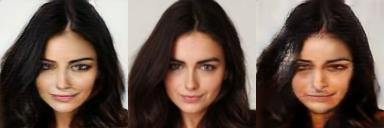

In [9]:
concat_image(row,1,3)

### black_smile -> brown_nosmile
black_smile -(smile2nosmile)-> black_nosmile -(black2brown)-> blond_nosmile  
black_smile -(black2blond)-> blond_smile -(smile2nosmile) -> blond_nosmile

### all_print

In [10]:
!ls ./drit_figure/

black2blond.jpg		     lib2nolib.jpg
black2brown.jpg		     makeup2nomakeup.jpg
black_smile2blond_smile.jpg  makeup_lib2nomakeuplib.jpg
female2male.jpg		     nofh_female2fh_male.jpg
fh2nofh.jpg		     smile2nosmile.jpg


In [10]:
row = [
    Image.open('./drit_figure/black2blond.jpg'),
    Image.open('./drit_figure/black2brown.jpg'),
    Image.open('./drit_figure/smile2nosmile.jpg'),
    Image.open('./drit_figure/black_smile2brown_nosmile.jpg'),
    Image.new('RGB',(128, 128), (255, 255, 255)),
    Image.open('./drit_figure/fh2nofh.jpg'),
    Image.open('./drit_figure/male2female.jpg'),
    Image.open('./drit_figure/fh_male2nofh_female.jpg'),
    Image.new('RGB',(128, 128), (255, 255, 255)),
    Image.open('./drit_figure/makeup2nomakeup.jpg'),
    Image.open('./drit_figure/lib2nolib.jpg'),
    Image.open('./drit_figure/makeup_lib2nomakeuplib.jpg'),
]

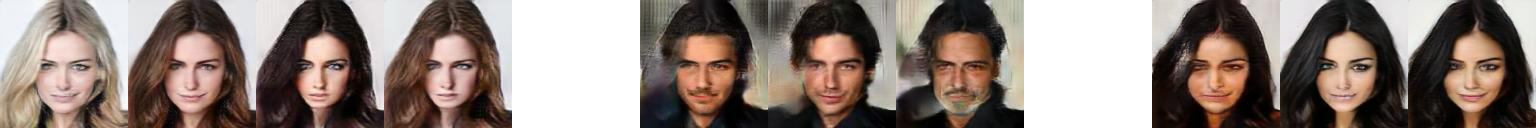

In [11]:
concat_image(row,1,12)